### Capstone Project - The Battle of the Neighborhoods

### -----Contents-----

1. Introduction: Business Problem
2. Data
3. Metholodology
4. Analysis
5. Results and Discussion
6. Conclusion

### 1.Introduction: Business Problem

A classmate of mine, who has immigrated with his family from Japan to America and want to open a Japanese Restaurant in New York City. He is only a small-business owner, so the best choice of him is to invest a small Restaurant in New York. We know hat there are a large number of Asia style restaurant in New York City, including korean, chinese, japanese, tailandese restaurants. So he want to know weather it is possible to open a japanese restaurant in New York City or not?

As a data scientist, I can help him to solve this problem and give some advise. Firstly, we need to know how many restaurants are in New York City, especially the number of the japanese restaurants in each Borough and neighbourhood. Secondly, the location, the ratings and tips of these restaurants are what we are interested.

*Buisiness Problem:*
Try to provide as much as more information of the Japanese restaurants in New York City so that my classmate could make a decision whether he can open a new Japanese restaurant or not?

### 2.Data

Accordding to this problem, some below data will be needed :
1. the geographical information of New York City: New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. the Data source is available here: https://cocl.us/new_york_dataset
2. Chinese restaurants and distribution in each neighborhood of NYC. We are going to use Foursquare API to get this data.
3. GeoSpace Data of venues in New York City. We can obtain these data from website: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

#### Data Collection

In [2]:
#import all the necessary packages.
import pandas as pd
import numpy as np
import requests
import os

import json

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from geopy.geocoders import Nominatim 
 # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.patches as patches
%matplotlib inline

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [35]:
#CLIENT_ID = 'HVXFPY1JQVGOSHMB0QZXYAVXFPP2XQTU5YF3BB2FCP2XCSOI' # your Foursquare ID
#CLIENT_SECRET = '3VT4R4UC5XN44LRES4ZHYESB44S1ZBRLQ2KOR2DZFTFVQBWR' # your Foursquare Secret
CLIENT_ID ='TXGUFZLGBYMAJ2TYK1T0RH1GMV3KUHHN2B11IPACWCNDHPEL'
CLIENT_SECRET='ES213PWSV2FAUVFVF5LKNHDTGQFZRKIS0FGUOYSBIVWJAPCW'
VERSION = '20180604'
#LIMIT = 10000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TXGUFZLGBYMAJ2TYK1T0RH1GMV3KUHHN2B11IPACWCNDHPEL
CLIENT_SECRET:ES213PWSV2FAUVFVF5LKNHDTGQFZRKIS0FGUOYSBIVWJAPCW


In [36]:
address = 'New York,NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 40.7127281, -74.0060152.


##### Download the data from internet

In [37]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [38]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [39]:
neighborhoods_data = newyork_data['features']

##### Transform the data to dataframe

In [40]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=column_names)

In [41]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [42]:
NY_neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [43]:
NY_neighborhoods.shape

(306, 4)

##### Plot the number of neighbourhoods for each borough in NYC

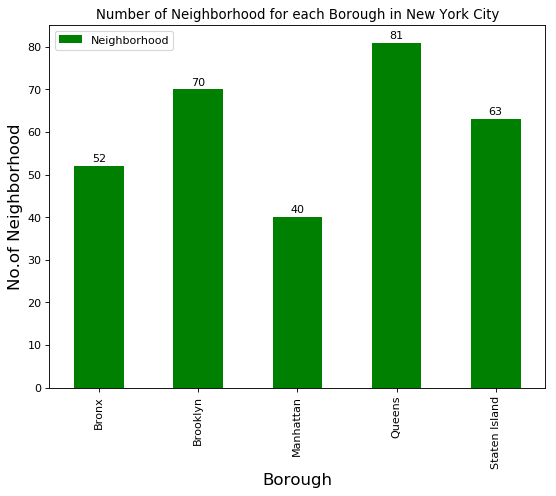

In [44]:
plt.figure(figsize=(8,6), dpi = 80)

# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
NY_neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='green')
#legend
plt.legend()
#show the number of each bar
for x,y in enumerate(NY_neighborhoods.groupby('Borough')['Neighborhood'].count()):
    plt.text(x,y+1,'%s' %round(y,1),ha='center')
#displays the plot
plt.show()

In [45]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=10000
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [46]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [47]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in NY_neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(NY_neighborhoods),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

In [48]:
japanese_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse
5,Bronx,Spuyten Duyvil,4b0b311af964a520642e23e3,Palace of Japan
6,Bronx,Spuyten Duyvil,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
7,Bronx,Castle Hill,54e0efc3498e7eda5dff1847,Sarku
8,Brooklyn,Bay Ridge,4b33fd94f964a520842325e3,Arirang Hibachi Steakhouse
9,Brooklyn,Bensonhurst,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant


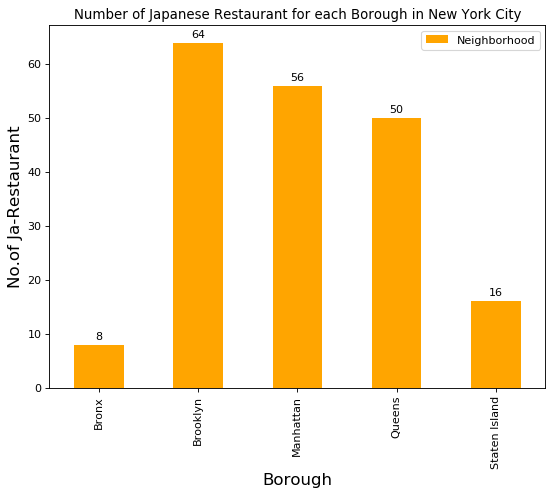

In [49]:
plt.figure(figsize=(8,6), dpi = 80)

# title
plt.title('Number of Japanese Restaurant for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Ja-Restaurant', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='orange')
#legend
plt.legend()
#show the number of each bar
for x,y in enumerate(japanese_rest_ny.groupby('Borough')['Neighborhood'].count()):
    plt.text(x,y+1,'%s' %round(y,1),ha='center')
#displays the plot
plt.show()

### 3.Methodology

We use this Analysis to provide enough information about the Japanese Restaurants In New York City for businessman.

Firstly,We have collected the geographical data from internet, which including the Borough and Neighbourhoods in New York city. According this data we could visualize the comparison of the number of Japanese restaurant in each borough and neighbourhood.

Secondly, we could get the detailed information about each japanese restaurant from Foursquare API. The information of name for each restaurant is the essential of this Analysis.

Thirdly, we know which Neighbourhood will be prefer to open a japanse resturant, we analysis each neighbourhood.

Finally, we con provide the information of common venue, where can be choosed by businessman. Then let him to make a disicion based on my analysis.

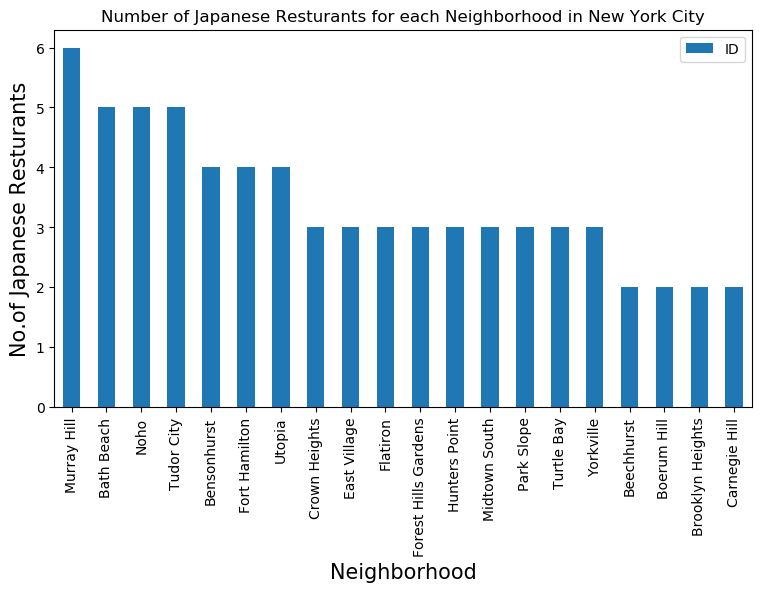

In [50]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [51]:
japanese_rest_ny.loc[japanese_rest_ny['Neighborhood'].isin(['Bath Beach','Noho','Tudor City','Bensonhurst','Fort Hamilton','Utopia'])]

,Borough,Neighborhood,ID,Name
9,Brooklyn,Bensonhurst,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
10,Brooklyn,Bensonhurst,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
11,Brooklyn,Bensonhurst,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
12,Brooklyn,Bensonhurst,4c326b9fa0ced13ac126156e,Ichi Sushi
37,Brooklyn,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
38,Brooklyn,Bath Beach,4bad45c9f964a52089403be3,Chikurin
39,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
40,Brooklyn,Bath Beach,4c326b9fa0ced13ac126156e,Ichi Sushi
41,Brooklyn,Bath Beach,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
60,Brooklyn,Fort Hamilton,4c2678eef1272d7f43a986c5,Fushimi


In [67]:
NY_sixja_Res=NY_neighborhoods.loc[NY_neighborhoods['Neighborhood'].isin(['Bath Beach','Noho','Tudor City','Bensonhurst','Fort Hamilton','Utopia'])]
NY_sixja_Res

,Borough,Neighborhood,Latitude,Longitude
47,Brooklyn,Bensonhurst,40.611009,-73.995180
79,Brooklyn,Bath Beach,40.599519,-73.998752
99,Brooklyn,Fort Hamilton,40.614768,-74.031979
248,Manhattan,Noho,40.723259,-73.988434
264,Queens,Utopia,40.733500,-73.796717
274,Manhattan,Tudor City,40.746917,-73.971219


### 4. Analysis

Now we analysis the six neighbourhoods(Bensonhurst,Bath Beach, Fort Hamilton, Noho, Utopia, Tudor).

From the result before, we know the neighbourhood Murray Hill has the most number of japannese Restaurant, when the businessman choose this neighbourhood, he will afford a big competition. For example, the neighbourhood Bath Beach has 5 japanese restaurants. So we analysis such neighbourhoods to find whether it has the oppotunity to open a japanese restaurant.

In [69]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [71]:
sixneibourhood_venues = getNearbyVenues(NY_sixja_Res['Neighborhood'],
                                   NY_sixja_Res['Latitude'],
                                   NY_sixja_Res['Longitude']
                                  )

Bensonhurst
Bath Beach
Fort Hamilton
Noho
Utopia
Tudor City


In [72]:
print(sixneibourhood_venues.shape)
sixneibourhood_venues.head()

(347, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bensonhurst,40.611009,-73.99518,il Colosseo,40.612221,-73.997436,Italian Restaurant
1,Bensonhurst,40.611009,-73.99518,Coco Nails,40.614735,-73.994620,Cosmetics Shop
2,Bensonhurst,40.611009,-73.99518,Il Fornaretto Bakery,40.613940,-73.999359,Bakery
3,Bensonhurst,40.611009,-73.99518,Frank And Sal's Prime Meats,40.610232,-73.999227,Butcher
4,Bensonhurst,40.611009,-73.99518,Tenzan,40.615265,-73.994046,Sushi Restaurant


In [74]:
# one hot encoding
sixneibourhood_onehot = pd.get_dummies(sixneibourhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sixneibourhood_onehot['Neighborhood'] = sixneibourhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sixneibourhood_onehot.columns[-1]] + list(sixneibourhood_onehot.columns[:-1])
sixneibourhood_onehot = sixneibourhood_onehot[fixed_columns]

sixneibourhood_onehot.head()

,Neighborhood,Adult Boutique,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Automotive Shop,Bagel Shop,...,Udon Restaurant,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bensonhurst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bensonhurst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bensonhurst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bensonhurst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bensonhurst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### The mean of the frequency of occurrence of each category

In [75]:
sixneibourhood_grouped = sixneibourhood_onehot.groupby('Neighborhood').mean().reset_index()
sixneibourhood_grouped

,Neighborhood,Adult Boutique,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Automotive Shop,Bagel Shop,...,Udon Restaurant,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bath Beach,0.00,0.000000,0.000000,0.00,0.00,0.020833,0.00,0.000000,0.000000,...,0.00,0.00,0.020833,0.020833,0.000000,0.00,0.00,0.000000,0.020833,0.000000
1,Bensonhurst,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.030303,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000
2,Fort Hamilton,0.00,0.000000,0.014286,0.00,0.00,0.014286,0.00,0.000000,0.028571,...,0.00,0.00,0.000000,0.014286,0.000000,0.00,0.00,0.014286,0.000000,0.000000
3,Noho,0.01,0.000000,0.020000,0.01,0.04,0.020000,0.01,0.000000,0.000000,...,0.01,0.01,0.000000,0.000000,0.000000,0.01,0.01,0.020000,0.000000,0.020000
4,Tudor City,0.00,0.000000,0.012346,0.00,0.00,0.024691,0.00,0.000000,0.012346,...,0.00,0.00,0.000000,0.000000,0.012346,0.00,0.00,0.012346,0.000000,0.012346
5,Utopia,0.00,0.066667,0.000000,0.00,0.00,0.000000,0.00,0.066667,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000


#### top 5 most common venues

In [76]:
num_top_venues = 5

for hood in sixneibourhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sixneibourhood_grouped[sixneibourhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                venue  freq
0         Pizza Place  0.06
1            Pharmacy  0.06
2     Bubble Tea Shop  0.04
3  Chinese Restaurant  0.04
4          Donut Shop  0.04


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.09
1    Sushi Restaurant  0.06
2      Ice Cream Shop  0.06
3                Park  0.06
4          Donut Shop  0.06


----Fort Hamilton----
                venue  freq
0      Sandwich Place  0.04
1            Pharmacy  0.04
2                Bank  0.04
3  Italian Restaurant  0.04
4         Pizza Place  0.04


----Noho----
                venue  freq
0  Italian Restaurant  0.06
1   French Restaurant  0.05
2        Cocktail Bar  0.04
3         Art Gallery  0.04
4            Boutique  0.03


----Tudor City----
                venue  freq
0                Park  0.06
1                Café  0.06
2  Mexican Restaurant  0.06
3    Greek Restaurant  0.05
4    Sushi Restaurant  0.05


----Utopia----
                       venue  freq
0      

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sixneibourhood_grouped['Neighborhood']

for ind in np.arange(sixneibourhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sixneibourhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pharmacy,Pizza Place,Bubble Tea Shop,Italian Restaurant,Fast Food Restaurant,Sushi Restaurant,Chinese Restaurant,Donut Shop,Kids Store,Clothing Store
1,Bensonhurst,Chinese Restaurant,Donut Shop,Sushi Restaurant,Dessert Shop,Ice Cream Shop,Park,Italian Restaurant,Butcher,Smoke Shop,Shabu-Shabu Restaurant
2,Fort Hamilton,Pizza Place,Pharmacy,Italian Restaurant,Sandwich Place,Bank,Gym / Fitness Center,Diner,Café,Pub,Chinese Restaurant
3,Noho,Italian Restaurant,French Restaurant,Art Gallery,Cocktail Bar,Gift Shop,Pizza Place,Mexican Restaurant,Rock Club,Coffee Shop,Boutique
4,Tudor City,Café,Park,Mexican Restaurant,Sushi Restaurant,Greek Restaurant,Diner,Deli / Bodega,Pizza Place,Asian Restaurant,Thai Restaurant
5,Utopia,Deli / Bodega,Indie Movie Theater,Basketball Court,History Museum,Donut Shop,Pizza Place,Playground,Chinese Restaurant,South American Restaurant,Spa


### 5. Result and Disscussion

From the analysis before, we know the asia restaurant from neighbourhood Bensonhurst and Utopia have the lowst frequency of occurance. But in neighbourhood Bensonhurst the 1rd most common venue is chinese restaurant and 3rd most common venue is the Sushi restaurant, it has already good asia restaursnts. For the neighbourhood Fort Hamilton, the 10th most Commom Venue is chinese restaurant, so I think there would be some people like asia food, probably the food isn't delicious enough, so this neighbourhood maybe a good choice. For the neighbourhood Utopia is the same situation as Fort Hamilton. In neighbourhood Noho we can't find such information, maybe the asia food is not so popular there. 


### 6. Conclusion

The best choice of this analysis would be neighbourhood Fort Hamilton and Utopia. Also I recommand the businessman to make a visit to these restaurant and try to find the weakness of their restaurants, at the same time to make a final decision.